<a href="https://colab.research.google.com/github/Jhansi-123/Project/blob/main/Text_Classification_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Deep Learning CNN Models

<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/banner.jpeg?raw=1">

When it comes to text data, sentiment analysis is one of the most widely performed analysis on it. Sentiment Analysis has been through tremendous improvements from the days of classic methods to recent times where in the state of the art models utilize deep learning to improve the performance.

Convolutional Neural Networks or CNNs are the work-horse of the deep learning world. They have, in some sense, brought deep learning research into mainstream discussions. The advancements in the image classification world has left even humans behind.

<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/cnn.png?raw=1">
In this project, we will attempt at performing sentiment analysis utilizing the power of CNNs.

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 287 kB 8.0 MB/s 
     |████████████████████████████████| 106 kB 75.8 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [ ]:
dataset = pd.read_csv('movie_reviews.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Prepare Train Test Split

In [ ]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Text Wrangling & Normalization

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:06<00:00, 2351.71it/s]

CPU times: user 21.2 s, sys: 168 ms, total: 21.4 s
Wall time: 21.4 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175795), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175796
Number of Documents=35000


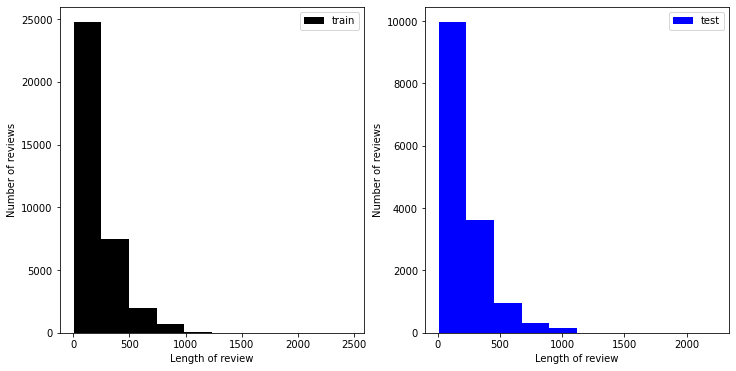

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens,color="black")
ax[0].set_xlabel('Length of review')
ax[0].set_ylabel('Number of reviews')
ax[0].legend(['train'], loc='upper right')


h2 = ax[1].hist(test_lens,color="blue")
ax[1].set_xlabel('Length of review')
ax[1].set_ylabel('Number of reviews')

ax[1].legend(['test'], loc='upper right')




### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:

VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [ ]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         52738800  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

## Model Training

In [ ]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
247/247 [==============================] - 60s 190ms/step - loss: 0.4038 - accuracy: 0.7844 - val_loss: 0.2679 - val_accuracy: 0.8874
Epoch 2/2
247/247 [==============================] - 46s 187ms/step - loss: 0.1272 - accuracy: 0.9548 - val_loss: 0.2680 - val_accuracy: 0.8977


## Model Evaluation

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions[:10]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [ ]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

Epoch 1/2
985/985 [==============================] - 88s 89ms/step - loss: 0.0830 - accuracy: 0.9716 - val_loss: 0.3389 - val_accuracy: 0.8846
Epoch 2/2
985/985 [==============================] - 88s 89ms/step - loss: 0.0305 - accuracy: 0.9898 - val_loss: 0.4285 - val_accuracy: 0.8809
Epoch 1/2
422/422 [==============================] - 38s 89ms/step - loss: 0.2567 - accuracy: 0.8977 - val_loss: 0.2263 - val_accuracy: 0.8993
Epoch 2/2
422/422 [==============================] - 38s 90ms/step - loss: 0.0482 - accuracy: 0.9844 - val_loss: 0.3119 - val_accuracy: 0.9033


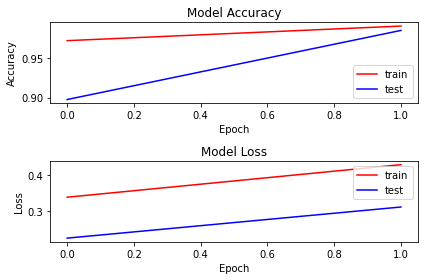

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
plt.subplot(2,1,1)
history1 = model.fit(X_train, y_train, validation_split=0.1, epochs=2, callbacks= [early_stopping], verbose=1)
history2 = model.fit(X_test, y_test, validation_split=0.1, epochs=2, callbacks= [early_stopping], verbose=1)
plt.plot(history1.history['accuracy'], 'r', history2.history['accuracy'], 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')


plt.subplot(2,1,2)
plt.plot(history1.history['val_loss'], 'r', history2.history['val_loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
accuracy=print("Accuracy: %.2f%%" % (scores[1]*100))


469/469 [==============================] - 7s 16ms/step - loss: 0.0361 - accuracy: 0.9895
Accuracy: 98.95%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.93      0.87      0.90      7490
    positive       0.88      0.93      0.91      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6549,941
positive,525,6985
